In [7]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
from glob import glob
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, AveragePooling2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
# Set parameters
IMAGE_SIZE = (224, 224)

In [41]:
print(len(os.listdir("/content/drive/MyDrive/masks_dataset")))

6000


In [42]:
train_files = []
mask_files = glob('/content/drive/MyDrive/masks_dataset/*_mask*')
for i in mask_files:
     train_files.append(i.replace('_mask', ''))

In [43]:
df = pd.DataFrame({"image_path": train_files, "mask_path":mask_files})

def diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value:
        return 1
    else:
        return 0

df['mask'] = df["mask_path"].apply(lambda x: diagnosis(x))


In [44]:
df.head()

,image_path,mask_path,mask
0,/content/drive/MyDrive/masks_dataset/no1239.jpg,/content/drive/MyDrive/masks_dataset/no1239_ma...,0
1,/content/drive/MyDrive/masks_dataset/no321.jpg,/content/drive/MyDrive/masks_dataset/no321_mas...,0
2,/content/drive/MyDrive/masks_dataset/y518.jpg,/content/drive/MyDrive/masks_dataset/y518_mask...,1
3,/content/drive/MyDrive/masks_dataset/no834.jpg,/content/drive/MyDrive/masks_dataset/no834_mas...,0
4,/content/drive/MyDrive/masks_dataset/no898.jpg,/content/drive/MyDrive/masks_dataset/no898_mas...,0


In [45]:
df['mask'].value_counts()

1    1500
0    1500
Name: mask, dtype: int64

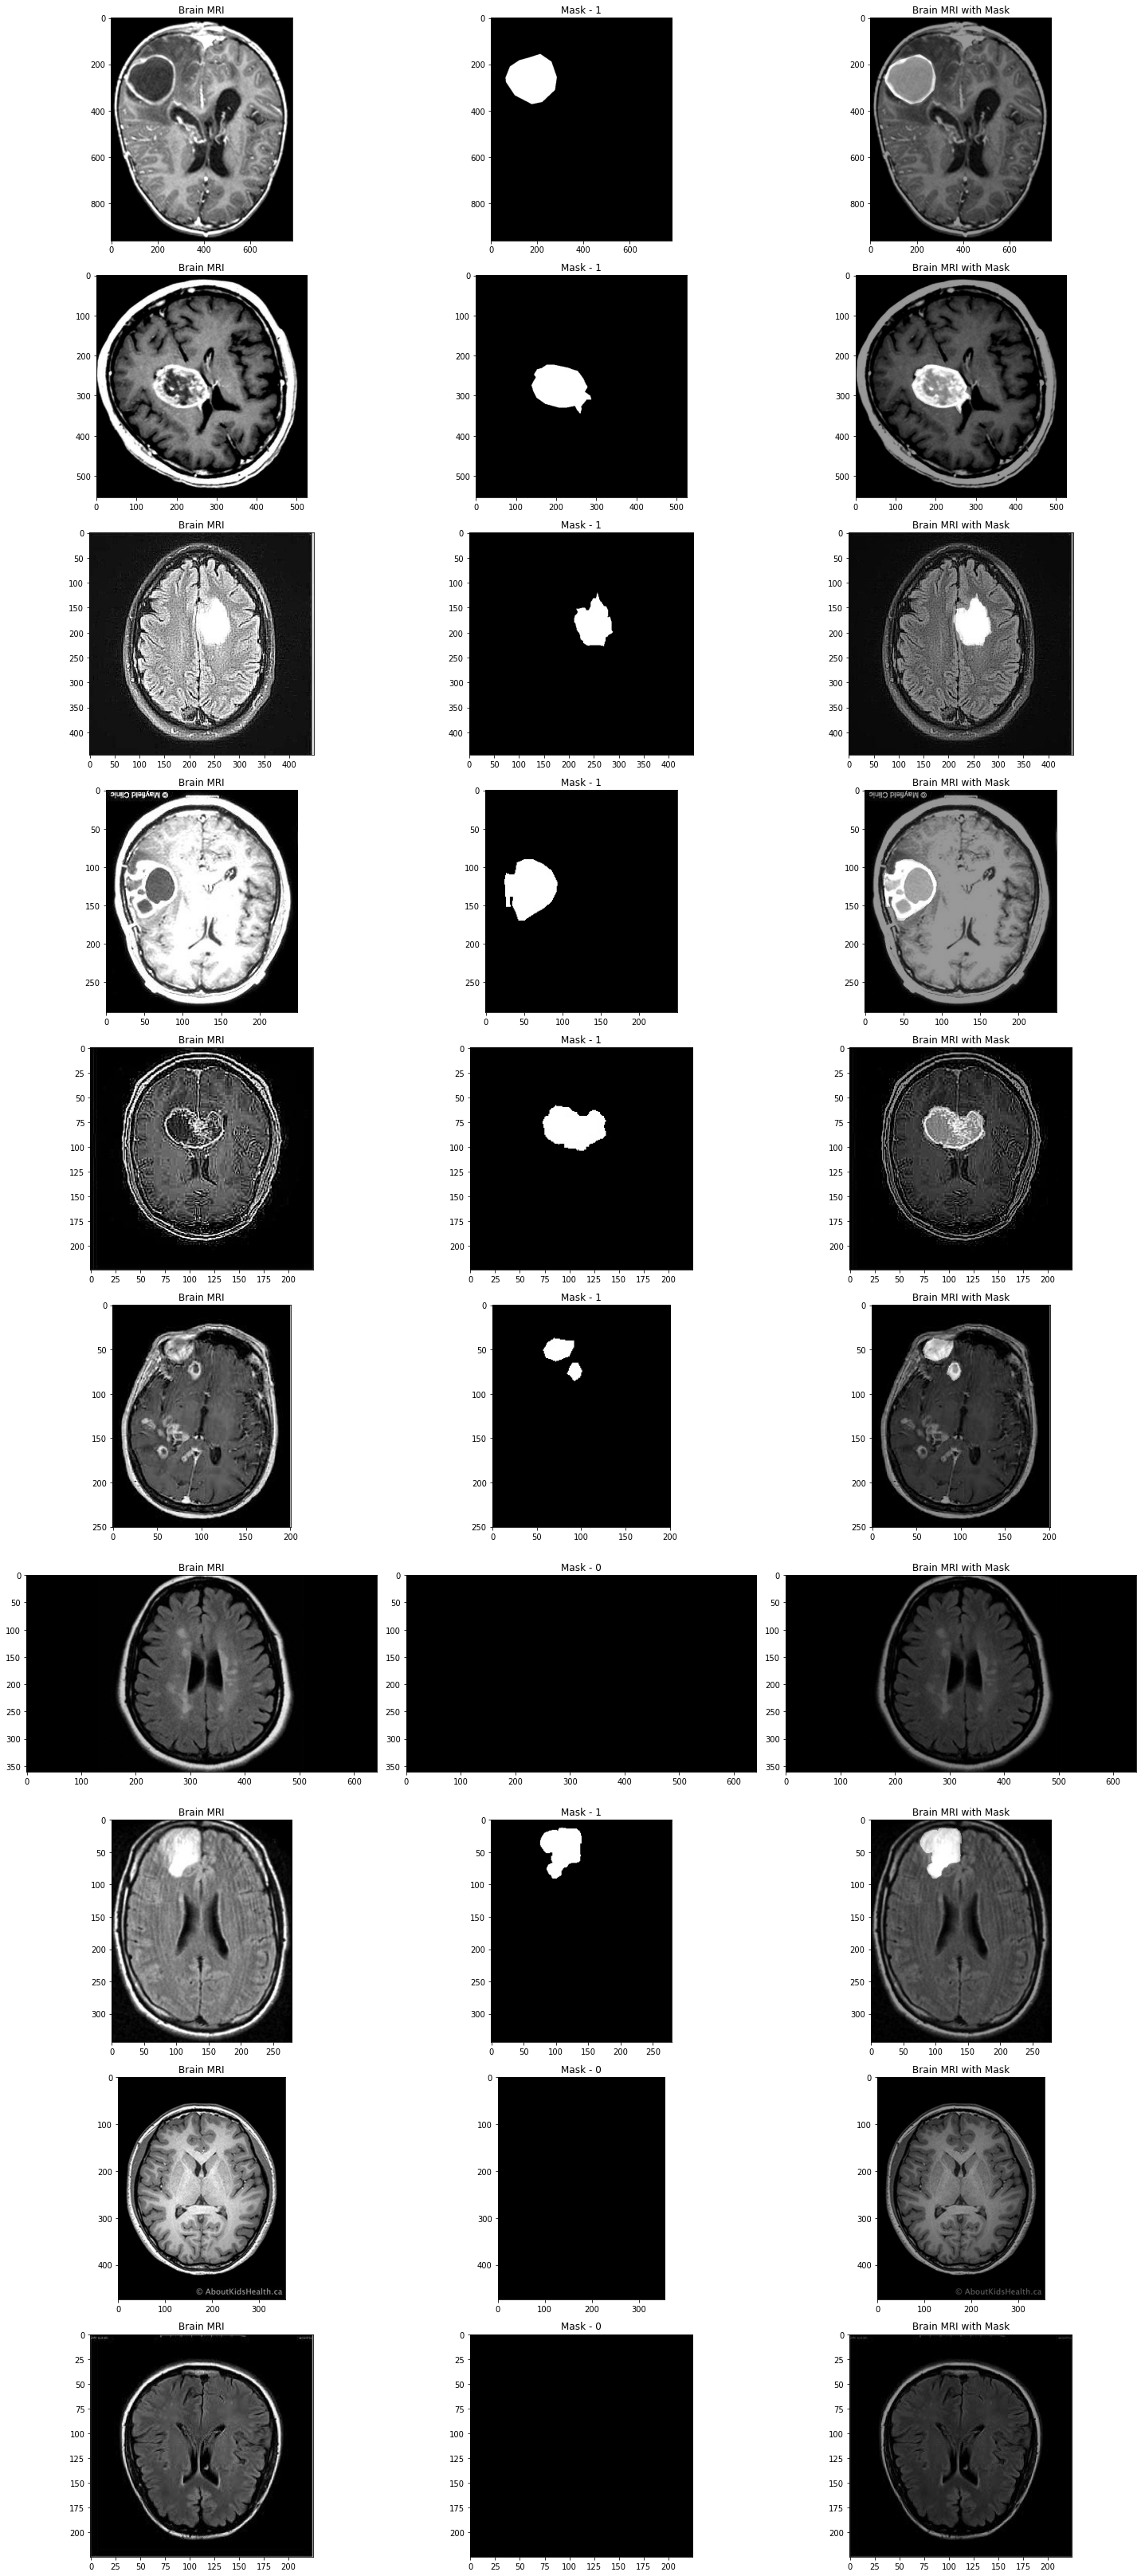

In [46]:
fig, ax = plt.subplots(10,3,figsize=(20,45))
for x in range(10):
    i = random.randint(0, len(df))
    img = cv2.imread(df['image_path'][i])
    mask = cv2.imread(df['mask_path'][i])
    ax[x][0].title.set_text("Brain MRI")
    ax[x][0].imshow(img)
    ax[x][1].title.set_text("Mask - " + str(df['mask'][i]))
    ax[x][1].imshow(mask)
    ax[x][2].title.set_text("Brain MRI with Mask")
    ax[x][2].imshow(img)
    ax[x][2].imshow(mask, alpha=0.4)
plt.tight_layout()

In [47]:
df['mask'] = df['mask'].apply(lambda x: str(x))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3000 non-null   object
 1   mask_path   3000 non-null   object
 2   mask        3000 non-null   object
dtypes: object(3)
memory usage: 70.4+ KB


In [48]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.15)
df_train, df_val = train_test_split(df_train, test_size=0.15)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2167, 3)
(383, 3)
(450, 3)


In [49]:
datagen = ImageDataGenerator(rescale=1/255.)
train_generator = datagen.flow_from_dataframe(df_train, 
                                             x_col='image_path',
                                             y_col='mask',
                                             class_mode='categorical',
                                             batch_size=32,
                                             shuffle=True,
                                             target_size=IMAGE_SIZE)
validation_generator = datagen.flow_from_dataframe(df_val,
                                                  x_col='image_path',
                                                  y_col='mask',
                                                  class_mode='categorical',
                                                  batch_size=32,
                                                  shuffle=True,
                                                  target_size=IMAGE_SIZE)
test_generator = datagen.flow_from_dataframe(df_test,
                                            x_col='image_path',
                                            y_col='mask',
                                            class_mode='categorical',
                                            batch_size=32,
                                            shuffle=False,
                                            target_size=IMAGE_SIZE)

Found 2167 validated image filenames belonging to 2 classes.
Found 383 validated image filenames belonging to 2 classes.
Found 450 validated image filenames belonging to 2 classes.


In [50]:
base_model = tf.keras.applications.mobilenet.MobileNet(weights='imagenet', include_top=False, input_tensor=Input(shape=(224,224,3)))
# for layer in base_model.layers:
#     layer.trainable = False

x = base_model.output
x = AveragePooling2D(pool_size=(4,4))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(2, activation='softmax')(x)

model = Model(base_model.input, outputs=x)
model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
model.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
______________________________________________________________

In [51]:
es = EarlyStopping(monitor='val_loss',
                  mode='min',
                  verbose=1,
                  patience=10)
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/clf_model_mobilenet.hdf5',
                            verbose=1,
                            save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                             mode='min',
                             verbose=1,
                             patience=5,
                             min_denta=0.0001,
                             factor=0.2)
my_callbacks = [es, checkpoint, reduce_lr]

In [52]:
history = model.fit(train_generator,
                   epochs=30,
                   steps_per_epoch= train_generator.n // train_generator.batch_size,
                   validation_data=validation_generator,
                   validation_steps = validation_generator.n // validation_generator.batch_size,
                   callbacks=[my_callbacks])

Epoch 1/30
67/67 [==============================] - 1667s 24s/step - loss: 0.2362 - accuracy: 0.9124 - val_loss: 0.5910 - val_accuracy: 0.8892

Epoch 00001: val_loss improved from inf to 0.59103, saving model to /content/drive/MyDrive/clf_model_mobilenet.hdf5
Epoch 2/30
67/67 [==============================] - 24s 356ms/step - loss: 0.0521 - accuracy: 0.9799 - val_loss: 0.4830 - val_accuracy: 0.9290

Epoch 00002: val_loss improved from 0.59103 to 0.48303, saving model to /content/drive/MyDrive/clf_model_mobilenet.hdf5
Epoch 3/30
67/67 [==============================] - 24s 355ms/step - loss: 0.0707 - accuracy: 0.9785 - val_loss: 0.2097 - val_accuracy: 0.9602

Epoch 00003: val_loss improved from 0.48303 to 0.20970, saving model to /content/drive/MyDrive/clf_model_mobilenet.hdf5
Epoch 4/30
67/67 [==============================] - 24s 355ms/step - loss: 0.0401 - accuracy: 0.9888 - val_loss: 0.0303 - val_accuracy: 0.9972

Epoch 00004: val_loss improved from 0.20970 to 0.03030, saving model

In [53]:
model.evaluate(test_generator)

15/15 [==============================] - 278s 20s/step - loss: 0.0016 - accuracy: 0.9978


[0.0016483712242916226, 0.9977777600288391]

In [54]:
model.save("/content/drive/MyDrive/Soumaya - PFE/masks_models/clf_model_mobilenet1")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Soumaya - PFE/masks_models/clf_model_mobilenet1/assets
